In [1]:
import numpy as np
import time
from copy import deepcopy

from matplotlib import pyplot as plt
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

filename = '/mnt/Pallav 1/HI data/HI_data_1000cube_without_dbId.csv'

In [6]:
# Read big csv file to get M_HI

R_mol = 0.4
f_mol = R_mol/(R_mol+1)

#x, y, z = np.arange(256), np.arange(256), np.arange(285)
M_HI = np.zeros((256, 256, 285))

start = time.perf_counter()

with open(filename) as fhand:
    for row in fhand:
        col = row.split(',')
        
        try:
            pos_z = float(col[3])
        except:
            continue
        
        if pos_z >= 925: continue
        
        M_cgm = float(col[4])
        bx, by, bz = int(float(col[1])*256//1e3), int(float(col[2])*256//1e3), int(pos_z*285//925)
        try:
            M_HI[bx, by, bz] += M_cgm*(1-f_mol)
        except:
            if bx>=256 and by<256: M_HI[bx-1, by, bz] += M_cgm*(1-f_mol)
            elif bx<256 and by>=256: M_HI[bx, by-1, bz] += M_cgm*(1-f_mol)
            else: M_HI[bx-1, by-1, bz] += M_cgm*(1-f_mol)
        
print(time.perf_counter() - start, 'seconds to collect req. data.')

#np.save('M_HI.npy', M_HI)

390.18285161899985 seconds to collect req. data.


In [2]:
# Load saved M_HI

M_HI = np.load('M_HI.npy')

In [15]:
z_eff = 0.39

A_21 = 2.85e-15 #s^−1
f_21 = 1420.4e6 #s^-1
sol_mass = 1.989e30 #kg (Solar Mass in kg)
delta_nu = 1e6 #s^-1 (freq bin)
delta_om = 1 # (solid angle bin area)

h_P = 6.62607004e-34 #m^2 kg/s
c = 299792458 #m/s
m_h = 1.6735575e-27 #kg
k_B = 1.38064852e-23 #m^2 kg s^-2 K^-1

H0 = 67.8 #100h km/(s*Mpc), h = 0.678
OM_m, OM_r, OM_de, OM_k = 0.307, 0, 0.693, 0

def H(z):
    Hz = H0 * (1+z) * np.sqrt(OM_m*(1+z) + OM_r*(1+z)**2. + OM_de/(1+z)**2. + OM_k)
    return Hz

def chi(z1_, z2_): #returns dist in Mpc
    n = 1000
    ztemp = np.empty(n+1)
    h = (z2_ - z1_)/float(n)
    ztemp[0] = z1_
    f_even, f_odd = 0., 0.
    for i in range(1, n+1):
        ztemp[i] = z1_ + float(i) * h
    for i in range(1, int(n/2)):
        zz = ztemp[2*i]
        f_even = f_even + (1. / H(zz))
    for i in range(1, int(n/2)+1):
        zz = ztemp[2*i-1]
        f_odd = f_odd + (1. / H(zz))
    fz1 = (1. / H(z1_))
    fz2 = (1. / H(z2_))
    integral = h/3. * c/1e3 * (fz1 + 2.*f_even + 4.*f_odd + fz2)
    return integral

chi_z_eff = chi(0., z_eff)*3.086e22 #m

prefac = 3*h_P*c**2*A_21/(32*np.pi*m_h*k_B*f_21*((1+z_eff)*chi_z_eff)**2*delta_nu*delta_om) * sol_mass/0.678
#prefac = 3*h_P*c**3*A_21/(32*np.pi*m_h*k_B*f_21**2)*(1+z_eff)**2/H(z_eff) /(delta_nu*delta_om) * sol_mass/0.678

In [27]:
T_HI = prefac*M_HI

b_HI = 1.105
Omega_HI = 4.3/b_HI
T_HI_mean = 180*Omega_HI*0.678*(1+z_eff)**2/H(z_eff)*H0/1e3 #K

array3D = deepcopy(T_HI)

In [28]:
T_HI_mean

0.7448619143826849

<IPython.core.display.Javascript object>


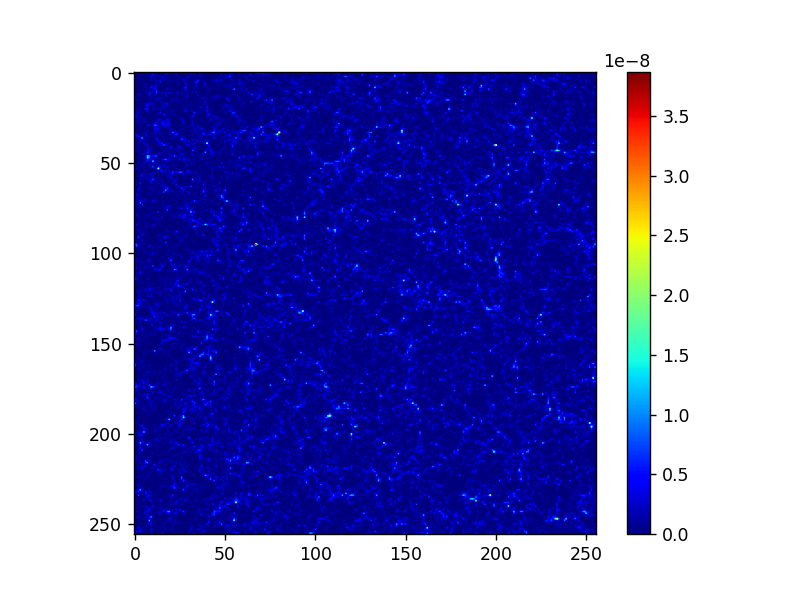

In [43]:
# Plot one slice

plt.imshow(array3D[:, :, 3], cmap='jet')
plt.colorbar()
plt.savefig('HIchannel4.png', dpi=200)

<IPython.core.display.Javascript object>


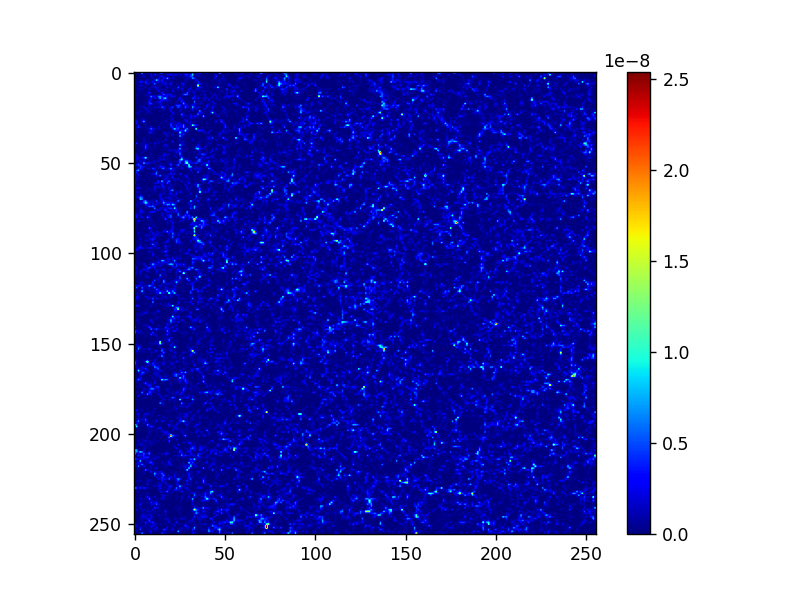

'\nPRESS J for PREV SLICE\nPRESS K for NEXT SLICE\n'

In [44]:
# Figure scrollable through channels

def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0] // 2
    im = ax.imshow(volume[ax.index], cmap='jet')
    fig.colorbar(im, orientation='vertical')
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()

def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index - 1) % volume.shape[0]  # wrap around using %
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index + 1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])

multi_slice_viewer(array3D.T)
'''
PRESS J for PREV SLICE
PRESS K for NEXT SLICE
'''

<IPython.core.display.Javascript object>


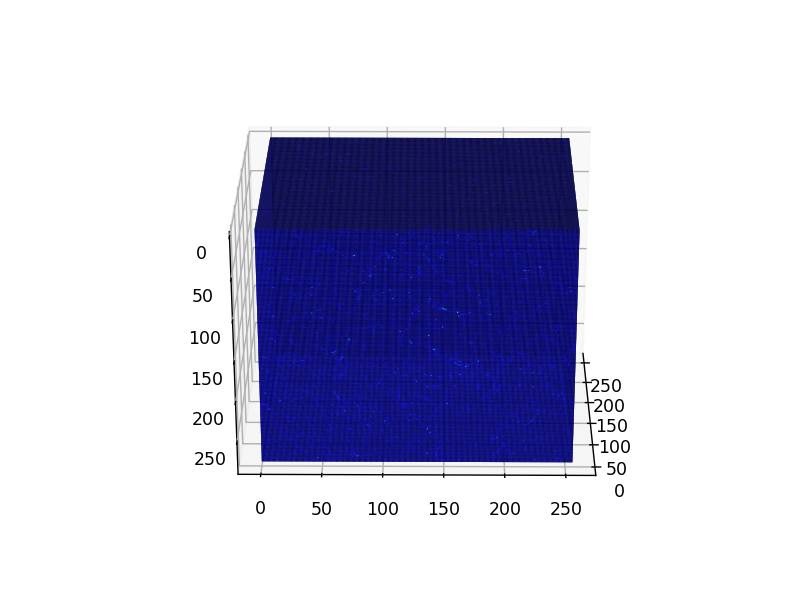

{(0, 0, 0): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x7fe77a981470>,
 (0, 0, 284): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x7fe779c62550>,
 (0, 1, 0): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x7fe779b0ecf8>,
 (0, 1, 284): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x7fe7799cc4e0>,
 (0, 2, 0): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x7fe779878c88>,
 (0, 2, 284): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x7fe779734470>,
 (0, 3, 0): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x7fe779663c18>,
 (0, 3, 284): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x7fe779523198>,
 (0, 4, 0): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x7fe7793e1a58>,
 (0, 4, 284): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x7fe77929e240>,
 (0, 5, 0): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x7fe77914a9e8>,
 (0, 5, 284): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x7fe7790081d0>,
 (0, 6, 0): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x7f

In [11]:
# Plot as 3D volume

array3D = deepcopy(M_HI)

fig = plt.figure()
ax = fig.gca(projection='3d')
#ax = fig.add_subplot(111, projection='3d')

filled = np.ones(array3D.shape).astype('bool')
norm = plt.Normalize()
colors = plt.cm.jet(norm(array3D))
#colors = plt.cm.jet(array3D/np.max(array3D))

ax.voxels(filled, facecolors=colors)
#plt.colorbar(colors)

In [ ]:
x, y, z = np.arange(256), np.arange(256), np.arange(285)
X, Y, Z = np.meshgrid(x, y, z)

fig = plt.figure()
ax = fig.add_subplot(122, projection='3d')

ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='winter', edgecolor='none')

#plt.imshow(M_HI[:, :, :3])
#plt.colorbar()

# REDUNDANT

In [19]:
l = 0
start = time.perf_counter()

with open(filename) as fhand:
    for line in fhand:
        l += 1

print(l, 'lines')
print(time.perf_counter() - start, 'seconds to go through, once.')

132697155 lines
681.8987089490001 seconds to go through, once.


In [3]:
R_mol = 0.4
f_mol = R_mol/(R_mol+1)

x, y, z, M_HI = [], [], [], []

start = time.perf_counter()

with open(filename) as fhand:
    for line in fhand:
        try:
            words = line.split(',')

            #if l == 0:
            #    l += 1
            #    #print(words[14], words[15], words[16], words[21])
            #    continue

            x.append(float(words[14]))
            y.append(float(words[15]))
            z.append(float(words[16]))

            M_cgm = float(words[21])
            M_HI.append(M_cgm*(1-f_mol))
            
            #l += 1
        except:
            continue

print(time.perf_counter() - start, 'seconds to collect req. data.')

#np.savez('data.npz', x=x, y=y, z=z, M_HI=M_HI)

0 lines
2050.107659491 seconds to collect req. data.
